In [37]:
from problem import get_train_data, get_test_data, WeightedClassificationError
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf
from time import time
import pandas as pd
import math
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
'''
  A simple Conv3D example with TensorFlow 2 based Keras
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D
from tensorflow.keras.utils import to_categorical
import h5py

In [3]:
# -- Preparatory code --
# Model configuration
batch_size = 32
no_epochs = 100
learning_rate = 0.001
no_classes = 8
validation_split = 0.2
verbosity = 1
sample_shape= (64,224,224,1)

In [4]:
videos_train, labels_train = get_train_data()

In [5]:
X_for_classifier= np.array(videos_train)
y_for_classifier= labels_train

In [6]:
videos_test, labels_test  = get_test_data()

In [7]:
Xtest_for_classifier = np.array(videos_test)
ytest_for_classifier = labels_test

In [8]:
from PIL import Image

def resize_frames(video):
    res=[]
    for frame in video:
        resized_img=Image.fromarray(frame).resize((128,128))
        res.append(np.array(resized_img))
    return np.array(res)

In [26]:
#function that gets all dataset
# 30 frames per video for 177 video = 2.65 gb !if considering each frame of float64
# as uint8 it takes 0.33 gb

def gen_videos(videolist):
    newvideos=[] # 177*30*250*250
    for video in videolist:
        reducedvideo= video.read_samples(video.frame_times[0:299:5])
        four=video.read_samples(video.frame_times[296:300])
        reducedvideo=np.concatenate((reducedvideo,four),axis=0) #[296-300[
        reducedvideo= reducedvideo.astype('uint8')        
        #CROP from 250 to 224
        reducedvideo=resize_frames(reducedvideo)
        #and add a batch dimension. dim= 1*30*250*250*3
        #reducedvideo = reducedvideo[None, ...]

        newvideos.append(reducedvideo)
    return newvideos

In [27]:
X_for_classifier= np.array(gen_videos(X_for_classifier))
X_for_classifier.shape

(177, 64, 128, 128)

In [28]:
Xtest_for_classifier= np.array(gen_videos(Xtest_for_classifier))
Xtest_for_classifier.shape

(100, 64, 128, 128)

In [29]:
train_videos=X_for_classifier
test_videos=Xtest_for_classifier
train_videos.shape

(177, 64, 128, 128)

In [30]:
def class_to_int(argument):
    switcher = {
        'A':0,
        'B':1,
        'C':2,
        'D':3,
        'E':4,
        'F':5,
        'G':6,
        'H':7,
    }
 
    # get() method of dictionary data type returns
    # value of passed argument if it is present
    # in dictionary otherwise second argument will
    # be assigned as default value of passed argument
    return switcher.get(argument, "nothing")

func=np.vectorize(class_to_int)
#Train
train_labels=func(y_for_classifier)
#Test
test_labels=func(ytest_for_classifier)

In [31]:
from sklearn.model_selection import train_test_split
train_videos,valid_videos,train_labels, valid_labels=train_test_split(X_for_classifier, train_labels, test_size=0.30)

In [32]:
print(
    "Number of samples in train and validation are %d and %d."
    % (train_videos.shape[0], valid_videos.shape[0])
)

Number of samples in train and validation are 123 and 54.


In [33]:
train_videos.shape

(123, 64, 128, 128)

In [42]:
train_videos=np.asarray(train_videos).transpose(0,2,3,1)
valid_videos=np.asarray(valid_videos).transpose(0,2,3,1)
test_videos=np.asarray(test_videos).transpose(0,2,3,1)

In [ ]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    print(type(augmented_volume))
    return augmented_volume


def preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [43]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((train_videos, train_labels))
validation_loader = tf.data.Dataset.from_tensor_slices((valid_videos, valid_labels))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(train_videos))
    #.map(preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(valid_videos))
    #.map(preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

(128, 128, 64)
Dimension of the CTscan is: (128, 128, 64)


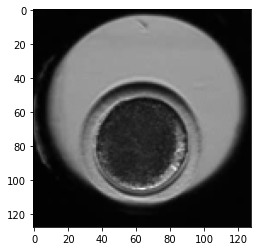

In [48]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print(image.shape)
print("Dimension of the CTscan is:", image.shape)
plt.imshow((image[:, :, 0]), cmap="gray")

In [49]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_4 (Conv3D)           (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 63, 63, 31, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 63, 63, 31, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])